In [1]:
from functions import *
from simulation import *
from policy_simulation import *
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random

In [2]:
# some hyperparameters that's will be fixed for the simulation 

################################################################################################
# we will consider n different call options
n = 2

# bid_range is n * n * ... * n = n^10
# for each call option, we will consider 10 different bid spreads

bid_values = np.linspace(0.1, 0.4, 4)
ask_values = np.linspace(0.1, 0.4, 4)

# we will consider n different call options, each option has len(bid_values) different bid spreads
# so bid_range will be high dimensional tensor of shape len(bid_values) * len(bid_values) * ... * len(bid_values) = len(bid_values)^n
bid_ranges = np.array(np.meshgrid(*[bid_values for _ in range(n)])).T.reshape(-1, n)
ask_ranges = np.array(np.meshgrid(*[ask_values for _ in range(n)])).T.reshape(-1, n)

################################################################################################


# the entire trading period is T
# each trading time step is dt
T = 1
dt = 0.1
r = 0 
S0 = 1.00

# generate the identity matrix of size n
V = np.eye(n)

# generate the strike prices for the n call options
K = np.linspace(0.8, 1.2, n)
time = np.linspace(10, 20, n)
A = 10
kappa = 1

# final value penalty 
phi = 1
# policy penalty: gamma
gamma = 0.1

# epoch is the number of trading we simulate over one stock_path
epoch = 1

In [3]:
# generate train data
# train data consist of 200 stock paths

class TrainData:
    def __init__(self, stock_path_repo, option_price_path_repo, delta_path_repo, gamma_path_repo):
        self.stock_path_repo = stock_path_repo
        self.option_price_path_repo = option_price_path_repo
        self.delta_path_repo = delta_path_repo
        self.gamma_path_repo = gamma_path_repo

def create_train_data(num_data):
    stock_path_repo = []
    option_price_path_repo = []
    delta_path_repo = []
    gamma_path_repo = []    
    for i in range(num_data):
        stock_path = stock_price_path(S0, 0.2, T, dt)
        option_price_path, delta_path, gamma_path = option_simulation(V, stock_path, T, dt, K, time, r, 0.2)
        stock_path_repo.append(stock_path)
        option_price_path_repo.append(option_price_path)
        delta_path_repo.append(delta_path)
        gamma_path_repo.append(gamma_path)
    return stock_path_repo, option_price_path_repo, delta_path_repo, gamma_path_repo

stock_price_repo, option_price_repo, delta_repo, gamma_repo = create_train_data(30)
train_data = TrainData(stock_price_repo, option_price_repo, delta_repo, gamma_repo)


In [4]:
train_data.stock_path_repo
# random select one element from a list
random.choice(train_data.stock_path_repo)

array([1.        , 0.98541598, 1.07008952, 1.04116735, 1.10249703,
       1.0699803 , 1.24901031, 1.06993824, 1.01520491, 0.98180783])

In [5]:
# save the train data
# train_data is an object
# stock_path_repo is a list of stock price paths
# option_price_path_repo is a list of option price paths
# delta_path_repo is a list of delta paths
# gamma_path_repo is a list of gamma paths

# save the train data
stock_price_data = train_data.stock_path_repo
option_price_data = train_data.option_price_path_repo
delta_data = train_data.delta_path_repo
gamma_data = train_data.gamma_path_repo

np.save('stock_price_data.npy', stock_price_data)
np.save('option_price_data.npy', option_price_data)
np.save('delta_data.npy', delta_data)
np.save('gamma_data.npy', gamma_data)


In [6]:
# I found that if there are so many parameters
# it is better to use a class to store all the parameters
class TradingParameters:
    def __init__(self, sigma, S0, T, dt, r, V, K, time, m, A, kappa, bid_ranges, ask_ranges, phi, gamma, epoch):
        self.sigma = sigma
        self.S0 = S0
        self.T = T
        self.dt = dt
        self.r = r
        self.V = V
        self.K = K
        self.time = time
        self.A = A
        self.kappa = kappa
        self.bid_ranges = bid_ranges
        self.ask_ranges = ask_ranges
        self.phi = phi
        self.gamma = gamma
        self.epoch = epoch

In [7]:
# initialize the initial policy and value network
paras = TradingParameters(0.2, S0, T, dt, r, V, K, time, 100, A, kappa, bid_ranges, ask_ranges, phi, gamma, epoch)
random_first_value = Net(n)
random_policy = TradingPolicy(random_first_value, paras.gamma, paras.A, paras.kappa, paras.bid_ranges, paras.ask_ranges)

# define value network to be trained
value_net_to_train = Net(n)
value_net_to_train.load_state_dict(random_first_value.state_dict())

# move the value_network to the GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
value_net_to_train.to(device)

Net(
  (fc1): Linear(in_features=6, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=1024, bias=True)
  (fc3): Linear(in_features=1024, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=1, bias=True)
)

In [8]:
# save random_first_value
torch.save(random_first_value.state_dict(), 'random_value_oarams')

In [9]:
# let's do the first policy iteration 
# current policy is random policy 
# current value_network to be trained is value_net_to_train

# training process
optimizer = optim.Adam(value_net_to_train.parameters(), lr = 0.01)
loss_path = value_estimation(value_net_to_train, random_policy, paras, optimizer, train_data, num_epoch = 100, lr = 0.01)

loss:  697250.3125
loss:  73.1404037475586
loss:  1020670.1875
loss:  4634.595703125
loss:  14553564.0
loss:  201744.625
loss:  74825.8984375
loss:  3148335.5
loss:  378798.5625
loss:  42941520.0
loss:  102567704.0
loss:  905923.5
loss:  7416928.0
loss:  3873183.25
loss:  11154709.0
loss:  13776078.0
loss:  5601584.0
loss:  8862796.0
loss:  2500817.25
loss:  2194878.5
loss:  5348053.0
loss:  1872699.5
loss:  3752321.0
loss:  863687.0
loss:  93277.71875
loss:  243182.5625
loss:  31803.82421875
loss:  2630852.0
loss:  386733.09375
loss:  31208608.0
loss:  1292358.5
loss:  15859.666015625
loss:  3637.494140625
loss:  15489929.0
loss:  601922.0
loss:  2341884.5
loss:  30794.5859375
loss:  9277.349609375
loss:  21824.71484375
loss:  83157.8359375
loss:  9100.0869140625
loss:  62975.046875
loss:  18368272.0
loss:  455106.0625
loss:  11128.9873046875
loss:  10696331.0
loss:  128546.9375
loss:  26252.44921875
loss:  707140.1875
loss:  38835.90234375
loss:  838992.375
loss:  97379.140625
loss: 

In [10]:
# save the value function's parameters
torch.save(value_net_to_train.state_dict(), 'first_value_net_params')
# save the loss path
loss_path = np.array(loss_path)
np.save('first_loss_path.npy', loss_path)

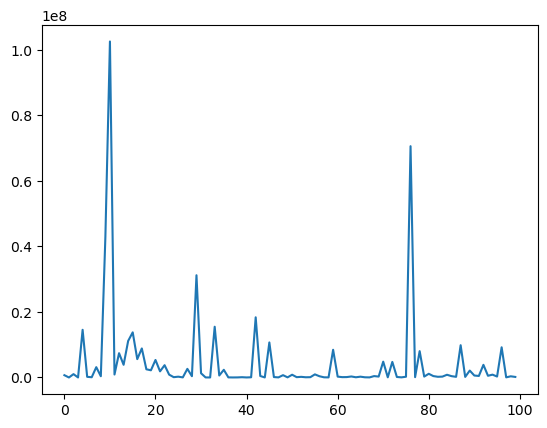

In [11]:
# plot the loss path
plt.plot(loss_path)
#plt.ylim(0, 30000000)
plt.show()


In [12]:
new_value_net = Net(n)
new_value_net.load_state_dict(torch.load("first_value_net_params"))

<All keys matched successfully>

In [13]:
# now, we have a new_value_net, 


second_policy = TradingPolicy(new_value_net, paras.gamma, paras.A, paras.kappa, paras.bid_ranges, paras.ask_ranges)

second_value_net = Net(n)   
second_value_net.to(device)
second_value_net.load_state_dict(new_value_net.state_dict())

second_loss_path = []

# training process
optimizer = optim.Adam(second_value_net.parameters(), lr = 0.01)
second_loss_path = value_estimation(second_value_net, second_policy, paras, optimizer, train_data, num_epoch = 100, lr = 0.01)


c:\Users\specf\OneDrive\Documents\GitHub\Option_Market_Making\2024_file\policy_simulation.py:132: RuntimeWarning: divide by zero encountered in log
  entropy = -np.sum(distribution * np.log(distribution), where=(distribution!=0))
c:\Users\specf\OneDrive\Documents\GitHub\Option_Market_Making\2024_file\policy_simulation.py:132: RuntimeWarning: invalid value encountered in multiply
  entropy = -np.sum(distribution * np.log(distribution), where=(distribution!=0))


loss:  59984.14453125
loss:  2939782.5
loss:  13801322.0
loss:  362727.9375
loss:  57526416.0
loss:  4229568.5
loss:  4608986.0
loss:  7872864.0
loss:  1100317.5
loss:  3804984.5
loss:  3485613.75
loss:  4364525.0
loss:  2995974.0
loss:  1585225.75
loss:  390908.84375
loss:  3161849.0
loss:  1351401.25
loss:  976695.6875
loss:  511145.375
loss:  109467.546875
loss:  1131368.375
loss:  777920.0
loss:  374590976.0
loss:  304172.5
loss:  1661553.0
loss:  5207057.0
loss:  2194229.75
loss:  122032.1796875
loss:  974111.375
loss:  742813.4375
loss:  6818728.0
loss:  2299348.25
loss:  594660.625
loss:  2874898.5
loss:  1668286.75
loss:  1098332.0
loss:  1386267.5
loss:  3567269.0
loss:  287994.6875
loss:  6797116.5
loss:  436523.9375
loss:  351732.03125
loss:  2407270.5
loss:  2885906.25
loss:  1214702.75
loss:  10513159.0
loss:  2317378.5
loss:  3710383.5
loss:  216636.421875
loss:  658281.375
loss:  1208449.0
loss:  2122076.5
loss:  567535.3125
loss:  199224.25
loss:  327223.25
loss:  33852

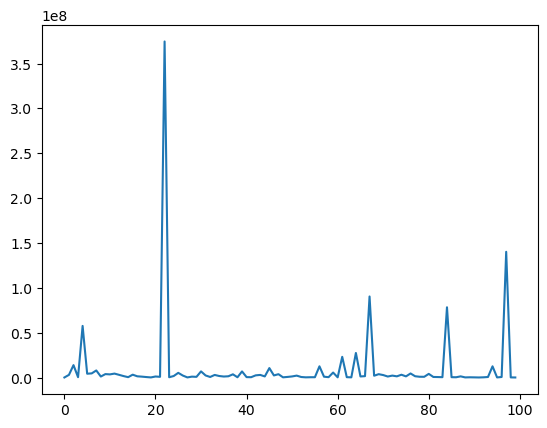

In [14]:
# plot the loss path    
# save the second value function's parameters
torch.save(second_value_net.state_dict(), "second_value_net_parameters")
second_loss_path = np.array(second_loss_path)
np.save('second_loss_path.npy', second_loss_path)
plt.plot(second_loss_path)

In [15]:
# train the third policy iteration 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
second_value_net = Net(n)
second_value_net.load_state_dict(torch.load("second_value_net_parameters"))
#third_value_net.to(device)
third_policy = TradingPolicy(second_value_net, paras.gamma, paras.A, paras.kappa, paras.bid_ranges, paras.ask_ranges)

third_value_net = Net(n)
third_value_net.load_state_dict(second_value_net.state_dict())
third_value_net.to(device)

third_loss_path = []
optimizer = optim.Adam(third_value_net.parameters(), lr = 0.01)
third_loss_path = value_estimation(third_value_net, third_policy, paras, optimizer, train_data, num_epoch = 100, lr = 0.01)



loss:  11636436.0
loss:  1067099.125
loss:  444132.875
loss:  2271543.25
loss:  1221825.0
loss:  162580.140625
loss:  1731793.625
loss:  2268939.0
loss:  210260.359375
loss:  23895.744140625
loss:  697595.9375
loss:  11079209.0
loss:  487238.0
loss:  52759.1328125
loss:  216549.375
loss:  68617.8359375
loss:  99209.6875
loss:  56709.47265625
loss:  3287487.5
loss:  698761.0
loss:  2026818.5
loss:  113769.046875
loss:  7639477.5
loss:  53445.33984375
loss:  165866.890625
loss:  16272957.0
loss:  191963.15625
loss:  299066.03125
loss:  1065188.0
loss:  96772672.0
loss:  315681.0625
loss:  283740.6875
loss:  196302.96875
loss:  475798.75
loss:  254127920.0
loss:  670306.1875
loss:  6780880.5
loss:  2688637.5
loss:  396090.34375
loss:  7879253.0
loss:  2247071.75
loss:  4156873.0
loss:  32936566.0
loss:  3674976.5
loss:  4415306.0
loss:  3889089.0
loss:  3866413.0
loss:  1824286.5
loss:  25388642.0
loss:  1849857.375
loss:  316561696.0
loss:  3254432.75
loss:  1085377.125
loss:  5563381.5


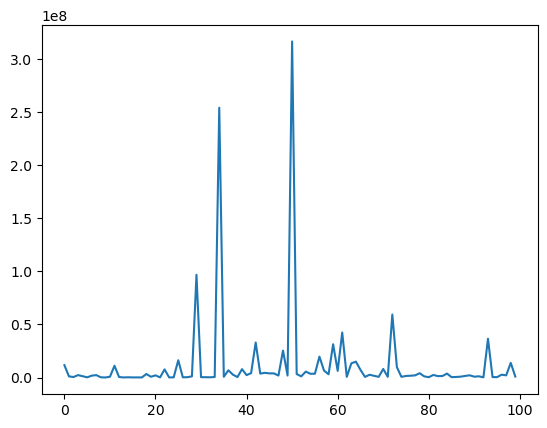

In [16]:
# save the third value function's parameters
torch.save(third_value_net.state_dict(), "third_value_net_parameters")
# save the loss path
third_loss_path = np.array(third_loss_path)
np.save('third_loss_path.npy', third_loss_path)

# plot the loss path
plt.plot(third_loss_path)

In [17]:
# train the fourth policy iteration
third_value_net = Net(n)
third_value_net.load_state_dict(torch.load("third_value_net_parameters"))


forth_policy = TradingPolicy(third_value_net, paras.gamma, paras.A, paras.kappa, paras.bid_ranges, paras.ask_ranges)
forth_value_net = Net(n)
forth_value_net.load_state_dict(third_value_net.state_dict())
forth_value_net.to(device)


forth_loss_path = []
optimizer = optim.Adam(forth_value_net.parameters(), lr = 10)
forth_loss_path = value_estimation(forth_value_net, forth_policy, paras, optimizer, train_data, num_epoch = 100, lr = 10)

loss:  8560847.0
loss:  3.583967116736231e+21
loss:  1.2102875617133855e+18
loss:  2.1560539975411302e+17
loss:  3.6556470241319715e+19
loss:  9.155652222346854e+16
loss:  3.4683874395868365e+17
loss:  760960562233344.0
loss:  47479.32421875
loss:  11876.7041015625
loss:  4.437206734418739e+16
loss:  1.0149969793122304e+18
loss:  6.233845550664385e+18
loss:  7060959.5
loss:  27892.974609375
loss:  192358512.0
loss:  266367.25
loss:  8865793.0
loss:  3.679760303689564e+17
loss:  231.369873046875
loss:  4144199.25
loss:  620637.5
loss:  146417.40625
loss:  88074112.0
loss:  6857.44384765625
loss:  6624.17041015625
loss:  29367812.0
loss:  144685.640625
loss:  556330.3125
loss:  40323096.0
loss:  712520.4375
loss:  152140.390625
loss:  12235312.0
loss:  2770.964111328125
loss:  6728.44384765625
loss:  4117.5126953125
loss:  191336.09375
loss:  1253771.25
loss:  5498.4072265625
loss:  10524517.0
loss:  10327.40234375
loss:  94793.9140625
loss:  37670116.0
loss:  28270410.0
loss:  3669.7392

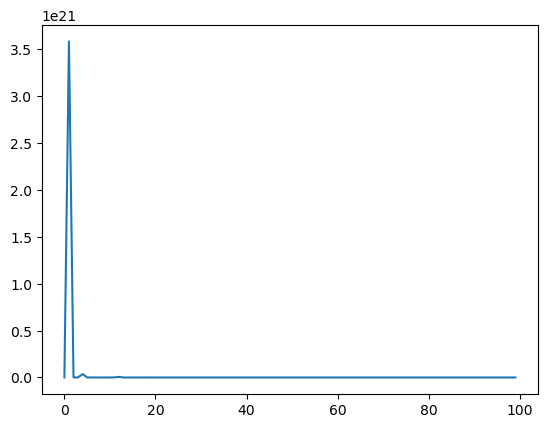

In [18]:
# save the forth value function's parameters
torch.save(forth_value_net.state_dict(), "forth_value_net_parameters")
# save the loss path
forth_loss_path = np.array(forth_loss_path)
np.save('forth_loss_path.npy', forth_loss_path)

# plot the loss path
plt.plot(forth_loss_path)